# Atividade 6 - Classificador Naive Bayes com Branch and Bound - Sem Normalização

Realizar validação cruzada para testar naiveBayes utilizando:

    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2
    
● Dependendo do seu dataset (tipos de variáveis) dá para utilizar uma implementação pronta de Naive Bayes ou ter que implementar a sua (talvez dê para combinar diferentes implementações)

● Quem tem missing values – possibilidade de não tratar antes e deixar isso para o algoritmo EM

● Para cada dataset fazer:

● Calibração do parâmetro utilizado na estimação MAP (no mínimo 2 valores: 0.1 e 1) via validação cruzada 10x – escolher aquele que apresentar maior acurácia média;

● Calcular os valores médios de revocação (sensibilidade), precisão e acurácia.

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st


import warnings

warnings.filterwarnings("ignore")

random_state=5007

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


### Características selecionadas pelo branch and Bound na atividade 4

In [3]:
selecionadas_continuas = ['Age',
                           'Number of sexual partners',
                           'First sexual intercourse', 
                           'Num of pregnancies',
                           'Hormonal Contraceptives (years)']

selecionadas_binarias = ['Hinselmann'
                        ]


## Pré-Processamento

In [4]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [5]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

#df_processed.isnull().sum()

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [6]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [7]:
df_imp = df_processed.copy()

In [8]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## Stratified Cross- Validation

### Dataset Desbalanceado

In [9]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, random_state,alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False):
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
    

    
    # Scores (das futuras metricas)
    scores = []

    alpha_min = int(alpha_min*100)
    alpha_max = int(alpha_max*100 +1)
    alpha_step = int(alpha_step*100)
    
    # Testa varios alphas
    for alpha_int in range (alpha_min, alpha_max, alpha_step):
        alpha = alpha_int * 0.01
        
        #Naive Bayes
        gnb = GaussianNB(var_smoothing=alpha)
        bnb = BernoulliNB(alpha=alpha)
        
        # Folds
        for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
            fold_number = fold
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_test, y_test = X.iloc[test_index], y.iloc[test_index]

            # quantidade de classes dentro da fold
            count_classes_fold = y.iloc[test_index].value_counts()
            # proporções
            prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
            prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
            print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                count_classes_fold[1],
                                                                                count_classes_fold[0], 
                                                                                count_classes_fold.sum(),
                                                                                prop_pos, prop_neg))

            # aplica Gaussian Naive Bayes em features continuas e Bernoulli Naive Bayes em binarias
            y_pred_g = gnb.fit(X_train[selecionadas_continuas], y_train)
            y_pred_b = bnb.fit(X_train[selecionadas_binarias], y_train)
            
            # Cria novo Dataset em que features são probabilidade da classe ser 1 para cada um dos classificadores (Gaussian e Bernoulli) 
            X_probs = pd.DataFrame(np.hstack((y_pred_g.predict_proba(X_train[selecionadas_continuas]), y_pred_b.predict_proba(X_train[selecionadas_binarias]))),
                        columns = ['0_G','1_G','0_B','1_B'])            
            
            X_probs_test = pd.DataFrame(np.hstack((y_pred_g.predict_proba(X_test[selecionadas_continuas]), y_pred_b.predict_proba(X_test[selecionadas_binarias]))),
                        columns = ['0_G','1_G','0_B','1_B'])
            
            # Aplica um novo Gaussian Naive Bayes sobre o novo dataset e classifica fold de teste
            y_pred = gnb.fit(X_probs, y_train).predict(X_probs_test)
            print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
             % (X_probs_test.shape[0], (y_test != y_pred).sum()))
           # print("Number of points predicted as Pos: %d"
           #  % ((y_pred == 1).sum()))

            # Scores do model (utilizados dados nao-balanceados) - dados de teste
            recall = recall_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            scores.append([alpha, fold_number, precision, recall, accuracy])
            
    return np.array(scores)
    



### Dataset Balanceado

In [10]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, random_state, alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False):
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []

    alpha_min = int(alpha_min*100)
    alpha_max = int(alpha_max*100 +1)
    alpha_step = int(alpha_step*100)
    
    # Testa varios alphas
    for alpha_int in range (alpha_min, alpha_max, alpha_step):
        alpha = alpha_int * 0.01
        
        #Naive Bayes
        gnb = GaussianNB(var_smoothing=alpha)
        bnb = BernoulliNB(alpha=alpha)
        
        # Folds
        for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
            fold_number = fold
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_test, y_test = X.iloc[test_index], y.iloc[test_index]

            # Normaliza MinMax para aplicar Smote
            X_train_normalized = minmax_scale.fit_transform(X_train)
            X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

            # SMOTETomek (apenas os dados de treino)
            print('\tBalanceando dados de treino fold {}...'.format(fold_number))
            X_train, y_train = cc.fit_resample(X_train_normalized, y_train)
            
            # Retorna para valores não normalizados
            X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
            print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                     y_train.value_counts()[0], 
                                                                                     y_train.value_counts()[1], 
                                                                                     ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                     ((y_train.value_counts()[1]/len(y_train))*100)))
            # quantidade de classes dentro da fold
            count_classes_fold = y_test.value_counts()
            # proporções
            prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
            prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
            print('\t\tDados de teste (desbalanceados)')
            print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                count_classes_fold[1],
                                                                                count_classes_fold[0], 
                                                                                count_classes_fold.sum(),
                                                                                prop_pos, prop_neg))


            # aplica Gaussian Naive Bayes em features continuas e Bernoulli Naive Bayes em binarias
            y_pred_g = gnb.fit(X_train[selecionadas_continuas], y_train)
            y_pred_b = bnb.fit(X_train[selecionadas_binarias], y_train)
            
            # Cria novo Dataset em que features são probabilidade da classe ser 1 para cada um dos classificadores (Gaussian e Bernoulli) 
            X_probs = pd.DataFrame(np.hstack((y_pred_g.predict_proba(X_train[selecionadas_continuas]), y_pred_b.predict_proba(X_train[selecionadas_binarias]))),
                       columns = ['0_G','1_G','0_B','1_B'])
            X_probs_test = pd.DataFrame(np.hstack((y_pred_g.predict_proba(X_test[selecionadas_continuas]), y_pred_b.predict_proba(X_test[selecionadas_binarias]))),
                                                  columns = ['0_G','1_G','0_B','1_B'])
            
            # Aplica um novo Gaussian Naive Bayes sobre o novo dataset e classifica fold de teste
            y_pred = gnb.fit(X_probs, y_train).predict(X_probs_test)
            print("\t\t\tNumero de instancias classificadas erradas do total de %d instancias : %d"
             % (X_probs_test.shape[0], (y_test != y_pred).sum()))
           # print("Number of points predicted as Pos: %d"
           #  % ((y_pred == 1).sum()))

            # Scores do model (utilizados dados nao-balanceados) - dados de teste
            recall = recall_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            scores.append([alpha, fold_number, precision, recall, accuracy])
            
    return np.array(scores)

## Calculando Precisão, Revocação e Acurácia

In [11]:
df_selecionado = df_imp[selecionadas_continuas]
df_selecionado = df_selecionado.join(df_imp[selecionadas_binarias])
df_selecionado = df_selecionado.join(df_imp['Biopsy'])

#df_selecionado

### Dataset Desbalanceado

In [12]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, random_state,alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Alpha', 1:'Fold', 2: 'Precision', 3: 'Recall', 4: 'Accuracy'}) 
print('----'*20)

K-Fold com K = 10
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas errad

In [13]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Branch_and_Bound-Sem_Normalizacao_NB.xlsx', 
                           encoding='utf-8-sig')

,Alpha,Fold,Precision,Recall,Accuracy
0,0.1,1.0,0.250000,0.600000,0.872093
1,0.1,2.0,0.750000,0.600000,0.965116
2,0.1,3.0,0.666667,0.800000,0.965116
3,0.1,4.0,1.000000,0.833333,0.988372
4,0.1,5.0,0.200000,0.166667,0.895349


### Dataset Balanceado

In [14]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, random_state,alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False))
scores_balanced = scores_balanced.rename(columns = {0: 'Alpha', 1:'Fold', 2: 'Precision', 3: 'Recall', 4: 'Accuracy'}) 
print('----'*20)

K-Fold com K = 10
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
			Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
			Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
			Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de

In [15]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Branch_and_Bound-Sem_Normalizacao_SVC.xlsx', 
                           encoding='utf-8-sig')

,Alpha,Fold,Precision,Recall,Accuracy
0,0.1,1.0,0.187500,0.600000,0.825581
1,0.1,2.0,0.666667,0.400000,0.953488
2,0.1,3.0,0.666667,0.800000,0.965116
3,0.1,4.0,1.000000,0.833333,0.988372
4,0.1,5.0,0.200000,0.166667,0.895349


## Calculando valor de alpha com maior acurácia

### Dataset Desbalanceado

In [16]:
mean_unbalanced = scores_unbalanced.groupby(['Alpha']).mean().drop('Fold', axis = 1)
mean_unbalanced

,Precision,Recall,Accuracy
Alpha,,,
0.1,0.610000,0.510000,0.941710
0.2,0.604848,0.453333,0.940547
0.3,0.703333,0.453333,0.949891
0.4,0.720000,0.453333,0.952216
0.5,0.753333,0.453333,0.953393
0.6,0.753333,0.453333,0.953393
0.7,0.753333,0.453333,0.953393
0.8,0.753333,0.453333,0.953393
0.9,0.753333,0.453333,0.953393


In [17]:
max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

0.5

### Dataset Balanceado

In [18]:
mean_balanced = scores_balanced.groupby(['Alpha']).mean().drop('Fold', axis = 1)
mean_balanced

,Precision,Recall,Accuracy
Alpha,,,
0.1,0.605417,0.473333,0.937059
0.2,0.611667,0.473333,0.941710
0.3,0.703333,0.453333,0.949891
0.4,0.753333,0.453333,0.953393
0.5,0.753333,0.453333,0.953393
0.6,0.753333,0.453333,0.953393
0.7,0.753333,0.453333,0.953393
0.8,0.753333,0.453333,0.953393
0.9,0.753333,0.453333,0.953393


In [19]:
max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

0.4

## Calculando intervalo de confiança da Acurácia para o melhor alpha

### Dataset Desbalanceado

In [20]:
# Usando apenas folds com o melhor alpha
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced['Alpha'] == max_alpha_unbalanced, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.953, IC = [0.935, 0.972]
Recall: Média = 0.453, IC = [0.277, 0.630]
Precisão: Média = 0.753, IC = [0.546, 0.960]


### Dataset Balanceado

In [21]:
# Usando apenas folds com o melhor alpha
metrics_balanced = scores_balanced.loc[scores_balanced['Alpha'] == max_alpha_balanced, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.953, IC = [0.935, 0.972]
Recall: Média = 0.453, IC = [0.277, 0.630]
Precisão: Média = 0.753, IC = [0.546, 0.960]


## Gráfico

In [22]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

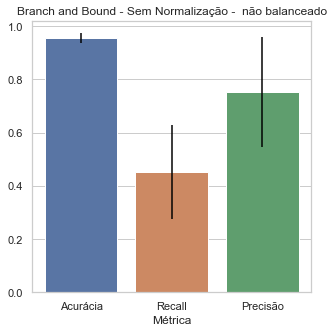

In [23]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

plot_unbalanced = pd.DataFrame(scores_unbalanced.loc[scores_unbalanced['Alpha'] == max_alpha_unbalanced, ['Accuracy']]).rename(columns={"Accuracy": "Value"})
plot_unbalanced['Métrica'] = 'Acurácia'

recall_unbalanced  = pd.DataFrame(scores_unbalanced.loc[scores_unbalanced['Alpha'] == max_alpha_unbalanced, ['Recall']]).rename(columns={"Recall": "Value"})
recall_unbalanced ['Métrica'] = 'Recall'
plot_unbalanced  = plot_unbalanced .append(recall_unbalanced )

presicion_unbalanced  = pd.DataFrame(scores_unbalanced.loc[scores_unbalanced['Alpha'] == max_alpha_unbalanced, ['Precision']]).rename(columns={"Precision": "Value"})
presicion_unbalanced ['Métrica'] = 'Precisão'
plot_unbalanced  = plot_unbalanced .append(presicion_unbalanced)

#plot

ax = sns.barplot(x="Métrica", y="Value", data=plot_unbalanced , ci = None)
plt.title('Branch and Bound - Sem Normalização -  não balanceado')

plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Branch and Bound - Sem Normalização - não balanceado', bbox_inches='tight', dpi=600)





ax.set(ylabel='')

### Dataset balanceado

[Text(152.00000000000003, 0.5, '')]

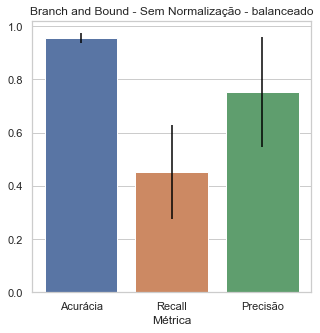

In [24]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

plot_balanced = pd.DataFrame(scores_balanced.loc[scores_balanced['Alpha'] == max_alpha_balanced, ['Accuracy']]).rename(columns={"Accuracy": "Value"})
plot_balanced['Métrica'] = 'Acurácia'

recall_balanced  = pd.DataFrame(scores_balanced.loc[scores_balanced['Alpha'] == max_alpha_balanced, ['Recall']]).rename(columns={"Recall": "Value"})
recall_balanced ['Métrica'] = 'Recall'
plot_balanced  = plot_balanced .append(recall_balanced )

presicion_balanced  = pd.DataFrame(scores_balanced.loc[scores_balanced['Alpha'] == max_alpha_balanced, ['Precision']]).rename(columns={"Precision": "Value"})
presicion_balanced ['Métrica'] = 'Precisão'
plot_balanced  = plot_balanced .append(presicion_balanced)

#plot

ax = sns.barplot(x="Métrica", y="Value", data=plot_balanced, ci =None )
plt.title('Branch and Bound - Sem Normalização - balanceado')

plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Branch and Bound - Sem Normalização - balanceado', bbox_inches='tight', dpi=600)


ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [25]:
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 
score_min_unbalanced = pd.DataFrame([acc_min_unbalanced, rec_min_unbalanced, pre_min_unbalanced]).rename(columns = {0: 'Score'})
score_max_unbalanced =  pd.DataFrame([acc_max_unbalanced, rec_max_unbalanced, pre_max_unbalanced]).rename(columns = {0: 'Score'})
score_min_balanced = pd.DataFrame([acc_min_balanced, rec_min_balanced, pre_min_balanced]).rename(columns = {0: 'Score'})
score_max_balanced =  pd.DataFrame([acc_max_balanced, rec_max_balanced, pre_max_balanced]).rename(columns = {0: 'Score'})


path_to_save = '../../model_results/'

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    '6',
    'Naive Bayes',
    'Branch and Bound Desbalanceado - Nao Normalizado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_unbalanced[metrica],score_min_unbalanced.loc[metrica]['Score'], score_max_unbalanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

for metrica in df_mean_balanced.index:
    result = [
    '6',
    'Naive Bayes',
    'Branch and Bound Balanceado - Nao Normalizado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value'],
     '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_balanced[metrica],score_min_balanced.loc[metrica]['Score'], score_max_balanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao', 
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

,Algoritmo,Atividade,Condicao,Melhores_Params,Metrica,Valor,Intervalo_Confianca
0,SVC,7,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.962709,"[0.963, 0.948, 0.978]"
1,SVC,7,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Recall,0.876667,"[0.877, 0.793, 0.960]"
2,SVC,7,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Precision,0.690079,"[0.690, 0.564, 0.816]"
3,Naive Bayes,6,Dataset Completo Balanceado - Nao Normalizado,0.8,Accuracy,0.93933,"[0.939, 0.917, 0.962]"
4,Naive Bayes,6,Dataset Completo Balanceado - Nao Normalizado,0.8,Recall,0.876667,"[0.877, 0.793, 0.960]"
5,Naive Bayes,6,Dataset Completo Balanceado - Nao Normalizado,0.8,Precision,0.547143,"[0.547, 0.433, 0.661]"
6,SVC,7,Dataset Completo Balanceado - Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.959193,"[0.959, 0.939, 0.979]"
7,SVC,7,Dataset Completo Balanceado - Normalizado,"('rbf', 100, '0.0001')",Recall,0.91,"[0.910, 0.821, 0.999]"
8,SVC,7,Dataset Completo Balanceado - Normalizado,"('rbf', 100, '0.0001')",Precision,0.673016,"[0.673, 0.529, 0.817]"
9,Naive Bayes,6,Dataset Completo Balanceado - Normalizado,0.2,Accuracy,0.935841,"[0.936, 0.914, 0.957]"


Resultados salvos com sucesso
